In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
from tqdm.auto import tqdm
import concurrent.futures
from multiprocessing import Pool
import copy,os,sys,psutil
from collections import Counter

In [2]:
import tensorflow as tf

# Tensorflow API解释

In [3]:
import tensorflow as tf
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# Normal Operation

## tf.add & tf.nn.bias_add
- [StackOverflow](https://stackoverflow.com/questions/43131606/whats-the-difference-of-add-methods-in-tensorflow)
>tf.add is a general addition operation, while tf.nn.bias_add is to be used specifically for adding bias to the weights, which **raises an exception if the dtypes aren't same.**
>
>Unlike **tf.add**, the **type of bias is allowed to differ from value** in the case where both types are quantized.

## tf.expand_dims & tf.reshape

In [62]:
a_ = [[[1,1],[2,2]],
      [[3,3],[4,4]]]
a_ = np.array(a_)
"a_",a_.shape

a = tf.Variable(a_,dtype=tf.float32)
"a",a.shape

a_tfreshape = tf.reshape(a,[2,2,2,-1])
"a_tfreshape",a_tfreshape.shape
a_tfexpand = tf.expand_dims(a,-1)
"a_tfexpand",a_tfexpand.shape

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("原始shape为")
    sess.run(tf.shape(a))
    print("-1 就是在最后一维上扩展一个")
    sess.run(tf.shape(tf.expand_dims(a,-1)))
    print("0 就是在第0维上扩展一个")
    sess.run(tf.shape(tf.expand_dims(a,0)))
    print("1 就是在第1维上扩展一个")
    sess.run(tf.shape(tf.expand_dims(a,1)))

('a_', (2, 2, 2))

('a', TensorShape([Dimension(2), Dimension(2), Dimension(2)]))

('a_tfreshape',
 TensorShape([Dimension(2), Dimension(2), Dimension(2), Dimension(1)]))

('a_tfexpand',
 TensorShape([Dimension(2), Dimension(2), Dimension(2), Dimension(1)]))

原始shape为


array([2, 2, 2], dtype=int32)

-1 就是在最后一维上扩展一个


array([2, 2, 2, 1], dtype=int32)

0 就是在第0维上扩展一个


array([1, 2, 2, 2], dtype=int32)

1 就是在第1维上扩展一个


array([2, 1, 2, 2], dtype=int32)

## tf.concat

In [24]:
a = np.random.randint(10,size=[2,3])
b = np.random.randint(10,size=[2,3])
print("a: {}\n".format(a.shape),a)
print("b: {}\n".format(b.shape),b)

c = tf.concat([a,b],axis=1)
with tf.Session() as sess:
    c_res = sess.run(c)
    print("c: {}\n".format(c_res.shape),c_res)

a: (2, 3)
 [[0 1 9]
 [4 9 0]]
b: (2, 3)
 [[1 7 9]
 [3 0 8]]
c: (2, 6)
 [[0 1 9 1 7 9]
 [4 9 0 3 0 8]]


## tf.stack
- stack要求两个tensor维度必须是相同的，本来是 $[D_1,D_2,..D_n]$ 的共n个维度的俩tensor，stack后变成n+1个维度，多+1的那个维度为`2`，具体这个+1的维度`2`放在哪就由`axis=`决定，`axis=0`那这个`2`就放在索引0上

shape为(3,4,5)的两个tensor在不同axis上做stack
- axis=0: (**2**,3,4,5)
- axis=1: (3,**2**,4,5)
- axis=2: (3,4,**2**,5)
- axis=3: (3,4,5,**2**)

stack三个维度相同的tensor那就是把`3`添加在`axis`指定的索引位置上

In [49]:
a = np.random.random([3,4,5])
b = np.random.random([3,4,5])
e = np.random.random([3,4,5])
c = tf.stack([a,b,e], axis=3)
a.shape
b.shape
c.shape

(3, 4, 5)

(3, 4, 5)

TensorShape([Dimension(3), Dimension(4), Dimension(5), Dimension(3)])

## tf.unstack
按`axis`指定的维度拆开，该维度取值是多少就拆成多少个tensor

shape为(3,4,5,2)的一个tensor在不同axis上做unstack
- axis=0: [(4,5,2)]*3
- axis=1: [(3,5,2)]*4
- axis=2: [(3,4,2)]*5
- axis=3: [(3,4,5)]*2

In [57]:
m = np.random.random([3,4,5,2])
m.shape
tf.unstack(m)
tf.unstack(m,axis=0)
tf.unstack(m,axis=1)
tf.unstack(m,axis=2)
tf.unstack(m,axis=3)

# ?tf.unstack

(3, 4, 5, 2)

[<tf.Tensor 'unstack_10:0' shape=(4, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_10:1' shape=(4, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_10:2' shape=(4, 5, 2) dtype=float64>]

[<tf.Tensor 'unstack_11:0' shape=(4, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_11:1' shape=(4, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_11:2' shape=(4, 5, 2) dtype=float64>]

[<tf.Tensor 'unstack_12:0' shape=(3, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_12:1' shape=(3, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_12:2' shape=(3, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_12:3' shape=(3, 5, 2) dtype=float64>]

[<tf.Tensor 'unstack_13:0' shape=(3, 4, 2) dtype=float64>,
 <tf.Tensor 'unstack_13:1' shape=(3, 4, 2) dtype=float64>,
 <tf.Tensor 'unstack_13:2' shape=(3, 4, 2) dtype=float64>,
 <tf.Tensor 'unstack_13:3' shape=(3, 4, 2) dtype=float64>,
 <tf.Tensor 'unstack_13:4' shape=(3, 4, 2) dtype=float64>]

[<tf.Tensor 'unstack_14:0' shape=(3, 4, 5) dtype=float64>,
 <tf.Tensor 'unstack_14:1' shape=(3, 4, 5) dtype=float64>]

## tf.reduce_mean
tf.reduce_mean, reduce_sum, reduce_max就是计算某一个维度上的均值、加和、最值
>tf.reduce_mean(input_tensor, axis=None, keepdims=None, name=None, reduction_indices=None, keep_dims=None)
- axis：
    - axis=None, 求全部元素的平均值；
    - axis=0, 列平均值；
    - axis=1，行平均值。 
- keep_dims：若值为True，可多行输出平均值。 
- name：自定义操作名。 
- ~~reduction_indices：axis的旧名，已停用。~~

In [1]:
np.random.seed(2019)
a = np.random.randint(0,10,size=[2,3])
"a",a
a_var = tf.Variable(a)
a_var.shape
a.shape
tf.reduce_mean(a,axis=None).shape
tf.reduce_mean(a,axis=0).shape
with tf.Session() as sess:
    sess.run(tf.reduce_sum(a,axis=None))
    sess.run(tf.reduce_mean(a,axis=None))
    sess.run(tf.reduce_mean(a,axis=None)).shape
    sess.run(tf.reduce_mean(a,axis=0))
    sess.run(tf.reduce_mean(a,axis=0)).shape

NameError: name 'tf' is not defined

## tf.transpose
> tf.transpose(a, perm=None, name='transpose', conjugate=False)
- a 需要转置的tensor
- perm （permute）转置的形式
    - `None` 表示把shape倒转过来，如[3,4]变成[4,3]，[1,2,3,4]变成[4,3,2,1]
    - `list[int]类型` 里面的int表示原始维度的索引按list里的顺序来排列
        - 如`[0,3,2,1]`表示原始的维度`3`放到第二个,`1`放到第四个（二、四维互换了）
        - 如`[1,3,2,0]`表示转置后的，按数字作为索引把原始的维度按当前list里的顺序重新排列

In [23]:
a = np.random.random([3,4,5,6])
a.shape
tf.transpose(a)
tf.transpose(a,[2,1,0,3])

(3, 4, 5, 6)

<tf.Tensor 'transpose_8:0' shape=(6, 5, 4, 3) dtype=float64>

<tf.Tensor 'transpose_9:0' shape=(5, 4, 3, 6) dtype=float64>

## tf.truncated_normal
按指定均值、标准差生成正态分布的数据，并且做两倍标准差截断
> tf.truncated_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None) :
- shape表示生成张量的维度
- mean是均值 | 默认为0
- stddev是标准差。 | 默认为1.0
- seed随机数种子
>
>这个函数产生正太分布，均值和标准差自己设定。这是一个截断的产生正太分布的函数，就是说产生正太分布的值如果与均值的差值大于两倍的标准差，那就重新生成。和一般的正太分布的产生随机数据比起来，这个函数产生的随机数与均值的差距不会超过两倍的标准差，但是一般的别的函数是可能的。

tf里的随机数种子，可以设置到图级别也可以设置为op级别
- 图级别：
```
# at some graph
tf.set_random_seed(2019)
tf.truncated_normal([3,4],stddev=0.1)
```
- op级别：
```
tf.truncated_normal([3,4],stddev=0.1,seed=2019)
```

类似的随机函数还有 `tf.random_uniform([3,4], -1, 1)` 生成-1到1的均匀分布的随机数
>tf.random_uniform(shape, minval=0, maxval=None, dtype=tf.float32, seed=None, name=None)

In [36]:
# truncated_normal 按正态分布生成数据，并且做标准差截断
with tf.Session() as sess:
    random_op = tf.truncated_normal([3,4],stddev=0.1,seed=2019)
    # random_op在一段程序里跑了三次，seed只控制程序每次相同位置生成时结果是一样的，而这三次则都不一样
    sess.run(random_op)
    sess.run(tf.cast(random_op,tf.int32))
    sess.run(tf.to_float(random_op,tf.int32))

array([[-0.01135067,  0.05639387, -0.04778707,  0.04571497],
       [ 0.1153388 ,  0.07203745,  0.15631334, -0.16913354],
       [ 0.124575  , -0.04655875,  0.0504917 ,  0.06605241]],
      dtype=float32)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32)

array([[ 0.04278614,  0.16716555, -0.01701541, -0.00202826],
       [ 0.11125483,  0.07280847, -0.07696502, -0.1261591 ],
       [-0.01496598, -0.01382563, -0.05033821, -0.02851957]],
      dtype=float32)

## tf.while_loop

In [17]:
i  = 0
n =10 

def cond(i, n):
    return i < n

def body(i, n):
    i = i + 1
    return i, n
i, n = tf.while_loop(cond, body, [i, n])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run([i,n])

[10, 10]

## tf.slice & tf.gather
- `tf.slice`: 按照指定的下标范围抽取连续区域的子集
    - 用得少，一般直接用索引 `[a:b,c:d,:-5]` 这种方式直接取（更pythonic）
- `tf.gather`: 按照指定的下标集合从axis=0中抽取子集，适合抽取不连续区域的子集

### tf.slice
> Note that tf.Tensor.getitem is typically a more pythonic way to perform slices, as it allows you to write foo[3:7, :-2] instead of tf.slice(foo, [3, 0], [4, foo.get_shape()[1]-2]).

即`tf.slice(tensor,[3,0],[4,tensor.get_shape()[1]-2])`等价于`tensor[3:7,-2]`

### tf.gather
```python
tf.gather(
    params,
    indices,
    validate_indices=None,
    name=None,
    axis=None,
    batch_dims=0
)
```

In [29]:
input = np.array([[[1, 1, 1], [2, 2, 2]],
                 [[3, 3, 3], [4, 4, 4]],
                 [[5, 5, 5], [6, 6, 6]]])
input.shape
print("如下两个是一样的，因为第三维总共就三个元素，取0:3就是所有的都取了")
input[1:2,0:1]
input[1:2,0:1,0:3]
print(">>> sess res as follow:")
with tf.Session() as sess:
    sess.run(tf.slice(input, [1, 0, 0], [1, 1, 3])) # 等价于 input[1:2,0:1,0:3]
    # [[[3, 3, 3]]]

    sess.run(tf.gather(input, [0, 2]))
    # 
    # [[[1, 1, 1], [2, 2, 2]],
    #  [[5, 5, 5], [6, 6, 6]]]

(3, 2, 3)

如下两个是一样的，因为第三维总共就三个元素，取0:3就是所有的都取了


array([[[3, 3, 3]]])

array([[[3, 3, 3]]])

>>> sess res as follow:


array([[[3, 3, 3]]])

array([[[1, 1, 1],
        [2, 2, 2]],

       [[5, 5, 5],
        [6, 6, 6]]])

## tf.cast
类型转换

In [11]:
wordEmbedding = np.array([[0.8,0.9,0.6,0.5],[0.1,0.2,0.3,0.4]])
wordEmbedding
tensor = tf.cast(wordEmbedding,dtype=tf.float32,name='word2vec')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tensor)

array([[0.8, 0.9, 0.6, 0.5],
       [0.1, 0.2, 0.3, 0.4]])

array([[0.8, 0.9, 0.6, 0.5],
       [0.1, 0.2, 0.3, 0.4]], dtype=float32)

## tf.argmax & tf.nn.softmax


In [106]:
a = [1,2,3,4]
a = [float(i) for i in a]
with tf.Session() as sess:
    tf.argmax(a).eval()
    tf.nn.softmax(a).eval()

3

array([0.0320586 , 0.08714432, 0.23688284, 0.6439143 ], dtype=float32)

In [173]:
sigmoid(1)
sigmoid(0)

0.7310585786300049

0.5

## tf.onehot
**API参数信息**
```python
tf.one_hot(
    indices,
    depth,
    on_value=None,
    off_value=None,
    axis=None,
    dtype=None,
    name=None
)
```
- 为索引`-1`保留了 `[0]*depth`的编码，索引`0`是从`[1,0,0...]`开始
    - 其他负数索引都为`[0]*depth`

`depth` 总数量 | 可以提供小于真实总数的值，逻辑是直接截断，`max(indices)+1`可以生效，但是如果再小的话max的数就被截断成0了

`indices` 即特征向量的`[32,104,22,33]`或者特征矩阵`[[22,11,44],[8,19],[88,33]]`

`on_value` 默认是 `1`, `off_value` 默认是 `0`

`axis`: 
> If the input indices is rank N, the output will have rank N+1. The new axis is created at dimension axis (default: the new axis is appended at the end).
- 当`indices`是特征**向量**时,`output_shape`:
```python
features x depth if axis == -1
depth x features if axis == 0
```
- 当`indices`是特征**矩阵**时,`output_shape`:
```python
batch x features x depth if axis == -1
batch x depth x features if axis == 1
depth x batch x features if axis == 0
```



In [13]:
indices = [-1,0,3,5,7]
depth = 8
with tf.Session() as sess:
    print(sess.run(tf.one_hot(indices,depth)))

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


# NN relevants

## tf.nn.zero_fraction
计算为0的比例

In [189]:
with tf.Session() as sess:
    tf.nn.zero_fraction([1,1,1,0]).eval()
    tf.nn.zero_fraction([1,1,0,0]).eval()

0.25

0.5

## tf.nn.embedding_lookup
```python
tf.nn.embedding_lookup(
    params,
    ids,
    partition_strategy='mod',
    name=None,
    validate_indices=True,
    max_norm=None
)
```

In [16]:
emb = np.array([[1,2,3,4],[0.1,0.2,0.3,0.4],[10,20,30,40],[100,200,300,400]])
emb.shape
word_idx = [[0,1,2,1],[0,2,2,2]]

with tf.Session() as sess:
    sess.run(tf.nn.embedding_lookup(emb,word_idx))

(4, 4)

array([[[ 1. ,  2. ,  3. ,  4. ],
        [ 0.1,  0.2,  0.3,  0.4],
        [10. , 20. , 30. , 40. ],
        [ 0.1,  0.2,  0.3,  0.4]],

       [[ 1. ,  2. ,  3. ,  4. ],
        [10. , 20. , 30. , 40. ],
        [10. , 20. , 30. , 40. ],
        [10. , 20. , 30. , 40. ]]])

## tf.nn.embedding_lookup_sparse
- 可以参考下[这篇简书的文章](https://www.jianshu.com/p/f54eb9715609)
```python
tf.nn.embedding_lookup_sparse(
    params,
    sp_ids,
    sp_weights,
    partition_strategy='mod',
    name=None,
    combiner=None,
    max_norm=None
)
```
- `sp_weights`可以直接填`None`
- 实际“查表”的时候就是用的`sp_ids`这个`sparseTensor`的`values`作为索引去`params`里查

In [46]:
emb = np.array([[1,2,3,4],
                [0.1,0.2,0.3,0.4],
                [10,20,30,40],
                [100,200,300,400],
                [1000,2000,3000,4000]
               ])

word_idx = [[0,1,2,1],
            [0,2,2,2]]

word_idx_sp = tf.sparse.SparseTensor(indices=[[0, 0], [1, 0], [2, 0]],
                              values=[2,3,4],
                              dense_shape=[10, 1])
word_idx_w = tf.sparse.SparseTensor(indices=word_idx_sp.indices,
                                    values=tf.ones_like(word_idx_sp.values),
                                    dense_shape=word_idx_sp.dense_shape)
with tf.Session() as sess:
    sess.run(word_idx_sp)
    sess.run(tf.sparse.to_dense(word_idx_sp))
    sess.run(tf.nn.embedding_lookup_sparse(emb,sp_ids=word_idx_sp,sp_weights=None,combiner='mean'))
    sess.run(tf.nn.embedding_lookup_sparse(emb,sp_ids=word_idx_sp,sp_weights=word_idx_w,combiner='mean'))


SparseTensorValue(indices=array([[0, 0],
       [1, 0],
       [2, 0]]), values=array([2, 3, 4], dtype=int32), dense_shape=array([10,  1]))

array([[2],
       [3],
       [4],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

array([[  10.,   20.,   30.,   40.],
       [ 100.,  200.,  300.,  400.],
       [1000., 2000., 3000., 4000.]])

array([[  10.,   20.,   30.,   40.],
       [ 100.,  200.,  300.,  400.],
       [1000., 2000., 3000., 4000.]])

## cross_entropy
**「注」：** tf的这批API，都是在内部做了sigmoid
- 测试用例是 `labels=[1,1,0,1],logits=[1,1,0,1]`
    - 内部是对`loigts`做了个`sigmoid`，即真正计算的是 `[1,1,0,1]` 和 `[0.731,0.731,0.5,0.731]`之间的CE**
    - `sigmoid(1)=0.731, sigmoid(0)=0.5`
    

一些参考
- 参考这篇[博客Tensorflow损失函数详解](https://sthsf.github.io/wiki/Algorithm/DeepLearning/Tensorflow%E5%AD%A6%E4%B9%A0%E7%AC%94%E8%AE%B0/Tensorflow%E5%9F%BA%E7%A1%80%E7%9F%A5%E8%AF%86---%E6%8D%9F%E5%A4%B1%E5%87%BD%E6%95%B0%E8%AF%A6%E8%A7%A3.html)

- 这篇[简书文章](https://www.jianshu.com/p/cf235861311b)结构更清晰

- CE公式
    - $H(X=x)=-\sum_x p(x)logq(x)$

- logloss
    - $logloss = - \sum_{i=1}^n(\frac{\hat{y_i}}{n}log(y_{pred})+\frac{1-\hat{y_i}}{n}log(1-y_{pred}))$

- 单看一条样本的logloss
    - $logloss = ylog(\hat{y}) + (1-y)log(1-\hat{y})$


In [175]:
class Data():
    # 每一行可有多个1,如一张图既有 label_桌子 又有 label_椅子
    multi_hot_labels=np.array([[1,0,0],
                               [0,1,0],
                               [0,0,1],
                               [1,1,0],
                               [0,1,0]],dtype=np.float32)
    
    # 每一行只有一个1,如一张图只能有 label_桌子 不能有 label_椅子
    one_hot_labels=np.array([[1,0,0],
                             [0,1,0],
                             [0,0,1],
                             [1,0,0],
                             [0,1,0]],dtype=np.float32)
    

    logits=np.array([[12,3,2],
                     [3,10,1],
                     [1,2,5],
                     [4,6.5,1.2],
                     [3,6,1]],dtype=np.float32)
    
    
Data.multi_hot_labels
Data.one_hot_labels
Data.logits

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 1., 0.],
       [0., 1., 0.]], dtype=float32)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

array([[12. ,  3. ,  2. ],
       [ 3. , 10. ,  1. ],
       [ 1. ,  2. ,  5. ],
       [ 4. ,  6.5,  1.2],
       [ 3. ,  6. ,  1. ]], dtype=float32)

### 如下是tensorflow计算CE的公式化简

「注」：这里已经把`sigmoid`考虑进去了，所以输入的时候`pred`就不要进行`sigmoid`了
- For brevity, let x = logits, z = labels. The logistic loss is
```python
z * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x))
= z * -log(1 / (1 + exp(-x))) + (1 - z) * -log(exp(-x) / (1 + exp(-x)))
= z * log(1 + exp(-x)) + (1 - z) * (-log(exp(-x)) + log(1 + exp(-x)))
= z * log(1 + exp(-x)) + (1 - z) * (x + log(1 + exp(-x))
= (1 - z) * x + log(1 + exp(-x))
= x - x * z + log(1 + exp(-x))
```
- For x < 0, to avoid overflow in exp(-x), we reformulate the above
```python
x - x * z + log(1 + exp(-x))
= log(exp(x)) - x * z + log(1 + exp(-x))
= - x * z + log(1 + exp(x))              
```
- Hence, to ensure stability and avoid overflow, the implementation uses this equivalent formulation
```python
max(x, 0) - x * z + log(1 + exp(-abs(x)))
```

In [156]:
from math import log,exp
def sigmoid(x):
    return 1/(1+np.exp(-x))

# 完全直接的CE，输入的是label和外部做好sigmoid的prediction
def exact_ce(pred,label):
    return -label*np.log(y_pred)-(1-label)*np.log(1-y_pred)

# tf化简公式（内部做了sigmoid，已化简掉了）
def ce_as_tf(pred,label):
    return max(pred, 0) - pred * label + log(1 + exp(-abs(pred)))

# 按计算公式计算（内部做了sigmoid）
def manual_formula(pred,label):
    y_pred = sigmoid(pred)
    E1 = -label*np.log(y_pred)-(1-label)*np.log(1-y_pred)
    return E1

ce_as_tf(1,1)
manual_formula(0.7,0.7) == ce_as_tf(0.7,0.7)

0.31326168751822286

True

### tf.nn.sigmoid_cross_entropy_with_logits
- 这个函数的输入是logits和labels，logits就是神经网络模型中的 W * X矩阵，注意**不需要经过sigmoid**
- 可用于各类别独立但不排斥的情况：如图片可以既有桌子又有凳子


In [169]:
# 5个样本三分类问题，且一个样本可以同时拥有多类
print(manual_formula(pred=Data.logits,label=Data.multi_hot_labels))     # 按计算公式计算的结果

with tf.Session() as sess:
    tf.nn.sigmoid_cross_entropy_with_logits(logits=Data.logits,labels=Data.multi_hot_labels).eval()
    tf.nn.sigmoid_cross_entropy_with_logits(logits=Data.logits,labels=Data.one_hot_labels).eval()

[[6.1989022e-06 3.0485876e+00 2.1269276e+00]
 [3.0485876e+00 4.5419773e-05 1.3132617e+00]
 [1.3132617e+00 2.1269276e+00 6.7153242e-03]
 [1.8149957e-02 1.5023305e-03 1.4632827e+00]
 [3.0485876e+00 2.4756414e-03 1.3132617e+00]]


array([[6.1441933e-06, 3.0485873e+00, 2.1269281e+00],
       [3.0485873e+00, 4.5398901e-05, 1.3132617e+00],
       [1.3132617e+00, 2.1269281e+00, 6.7153485e-03],
       [1.8149929e-02, 1.5023102e-03, 1.4632825e+00],
       [3.0485873e+00, 2.4756852e-03, 1.3132617e+00]], dtype=float32)

array([[6.1441933e-06, 3.0485873e+00, 2.1269281e+00],
       [3.0485873e+00, 4.5398901e-05, 1.3132617e+00],
       [1.3132617e+00, 2.1269281e+00, 6.7153485e-03],
       [1.8149929e-02, 6.5015025e+00, 1.4632825e+00],
       [3.0485873e+00, 2.4756852e-03, 1.3132617e+00]], dtype=float32)

### tf.nn.weighted_cross_entropy_with_logits
- 是`sigmoid_cross_entropy_with_logits`的拓展版，多支持一个`pos_weight`参数，在传统基于sigmoid的交叉熵算法上，**正样本算出的值乘以某个系数。**

```python
tf.nn.weighted_cross_entropy_with_logits(
    labels=None,
    logits=None,
    pos_weight=None,
    name=None,
    targets=None
)
```

In [171]:
# pos_weight = np.ones_like(logits.shape[0])
pos_weight = np.zeros_like(Data.logits.shape[0]) # 权重统一为0
with tf.Session() as sess:
    tf.nn.weighted_cross_entropy_with_logits(Data.multi_hot_labels,Data.logits, pos_weight, name=None).eval()
    tf.nn.weighted_cross_entropy_with_logits(Data.one_hot_labels,Data.logits, pos_weight, name=None).eval()

array([[0.       , 3.0485873, 2.126928 ],
       [3.0485873, 0.       , 1.3132617],
       [1.3132617, 2.126928 , 0.       ],
       [0.       , 0.       , 1.4632825],
       [3.0485873, 0.       , 1.3132617]], dtype=float32)

array([[0.       , 3.0485873, 2.126928 ],
       [3.0485873, 0.       , 1.3132617],
       [1.3132617, 2.126928 , 0.       ],
       [0.       , 6.5015025, 1.4632825],
       [3.0485873, 0.       , 1.3132617]], dtype=float32)

### ~~tf.nn.softmax_cross_entropy_with_logits~~ (Deprecated)
### tf.nn.softmax_cross_entropy_with_logits_v2
- 为了效率此函数内部执行softmax，输入logits时不要计算softmax
- While the **classes are mutually exclusive**, their probabilities need not be. All that is required is that **each row of labels is a valid probability distribution**
- Note that to avoid confusion, it is required to pass only named arguments to this function.


In [174]:
with tf.Session() as sess:
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=Data.multi_hot_labels,logits=Data.logits).eval()
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=Data.one_hot_labels,logits=Data.logits).eval()

array([1.6878611e-04, 1.0346780e-03, 6.5883912e-02, 2.6669841e+00,
       5.4985214e-02], dtype=float32)

array([1.6878611e-04, 1.0346780e-03, 6.5883912e-02, 2.5834920e+00,
       5.4985214e-02], dtype=float32)

### tf.nn.sparse_softmax_cross_entropy_with_logits
注意labels和logits的shape
- labels是第几类的索引
```python
   [2,
    1,
    1,
    2]
```
- logits是
```python
    [[ 12, 4,   4, 22],
     [6.5, 2, 3.3,  7],
     [2.5, 9, 8.3,6.7],]
```
>如果两个都是Rank1会报错： Rank of labels (received 1) should equal rank of logits minus 1 (received 1)

```python
tf.nn.sparse_softmax_cross_entropy_with_logits(
    _sentinel=None,
    labels=None,
    logits=None,
    name=None
)
```

In [185]:
# Data.multi_hot_labels
# tf.argmax(Data.multi_hot_labels,axis=-1).eval() # multi_hot（支持一图多类）的label做aargmax也没有意义
Data.one_hot_labels
Data.logits
label_rank1 = tf.argmax(Data.one_hot_labels,axis=-1)
logits_rank1 = tf.argmax(Data.logits,axis=-1)
with tf.Session() as sess:
    label_rank1.eval()
    logits_rank1.eval()
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label_rank1,logits=Data.logits).eval()
#     tf.nn.sparse_softmax_cross_entropy_with_logits(labels=,logits=Data.logits).eval()

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

array([[12. ,  3. ,  2. ],
       [ 3. , 10. ,  1. ],
       [ 1. ,  2. ,  5. ],
       [ 4. ,  6.5,  1.2],
       [ 3. ,  6. ,  1. ]], dtype=float32)

array([0, 1, 2, 0, 1])

array([0, 1, 2, 1, 1])

array([1.6878611e-04, 1.0346780e-03, 6.5883912e-02, 2.5834920e+00,
       5.4985214e-02], dtype=float32)

### 对比

In [187]:
with tf.Session() as sess:
    # softmax
    label_rank1=tf.argmax(Data.one_hot_labels,axis=-1)
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label_rank1,logits=Data.logits).eval()
    
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=Data.one_hot_labels,logits=Data.logits).eval()
    
    # sigmoid
    tf.nn.sigmoid_cross_entropy_with_logits(logits=Data.logits,labels=Data.one_hot_labels).eval()

    pos_weight=np.ones_like(Data.logits.shape[0]) # 权重统一为1
    tf.nn.weighted_cross_entropy_with_logits(Data.one_hot_labels,Data.logits, pos_weight, name=None).eval()

array([1.6878611e-04, 1.0346780e-03, 6.5883912e-02, 2.5834920e+00,
       5.4985214e-02], dtype=float32)

array([1.6878611e-04, 1.0346780e-03, 6.5883912e-02, 2.5834920e+00,
       5.4985214e-02], dtype=float32)

array([[6.1441933e-06, 3.0485873e+00, 2.1269281e+00],
       [3.0485873e+00, 4.5398901e-05, 1.3132617e+00],
       [1.3132617e+00, 2.1269281e+00, 6.7153485e-03],
       [1.8149929e-02, 6.5015025e+00, 1.4632825e+00],
       [3.0485873e+00, 2.4756852e-03, 1.3132617e+00]], dtype=float32)

array([[6.1441933e-06, 3.0485873e+00, 2.1269281e+00],
       [3.0485873e+00, 4.5398901e-05, 1.3132617e+00],
       [1.3132617e+00, 2.1269281e+00, 6.7153485e-03],
       [1.8149929e-02, 6.5015025e+00, 1.4632825e+00],
       [3.0485873e+00, 2.4756852e-03, 1.3132617e+00]], dtype=float32)

# CNN
## tf.nn.conv2d
```python
tf.nn.conv2d(
    input,
    filter=None,
    strides=None,
    padding=None,
    use_cudnn_on_gpu=True,
    data_format='NHWC',
    dilations=[1, 1, 1, 1],
    name=None,
    filters=None
)
```
找到的解释：
> tensorflow中的tf.nn.conv2d函数，实际上相当于用filter，以一定的步长stride在image上进行滑动，计算重叠部分的内积和，即为卷积结果

官方文档：
> input tensor of shape:  
> - [`batch`, **in_height**, **in_width**, **in_channels**]
>
> filter / kernel tensor of shape:   
>- [**filter_height**, **filter_width**, **in_channels**, `out_channels`]
>
>this op performs the following:
>- Flattens the filter to a 2-D matrix with shape:
>    - [**filter_height** * **filter_width** * **in_channels**, `output_channels`].
>- Extracts image patches from the input tensor to form a virtual tensor of shape:
>    - [`batch`, out_height, out_width, **filter_height** * **filter_width** * **in_channels**].
>- For each patch, right-multiplies the filter matrix and the image patch vector.


In [102]:
emb = np.array([[1,2,3,4,5,6],
                [0.1,0.2,0.3,0.4,0.5,0.6],
                [10,20,30,40,50,60],
                [100,200,300,400,500,600]])
# word_idx = [[0,1,2,1],[0,2,2,2]]
word_idx = [[0,1,2]]
embeddedWords = tf.cast(tf.nn.embedding_lookup(emb,word_idx),dtype=tf.float32)
embeddedWordsExpanded = tf.expand_dims(embeddedWords, -1)

embeddedWordsExpanded.shape
filterSize = 2 # 卷积核大小
embeddingSize = 6 # 词向量维度
in_channels =1 # 输入的通道
numFilters = 4 # 卷积核的个数
sequenceLength = len(word_idx[0]) # 句子长度，一般要padding
filterShape = [filterSize, embeddingSize, in_channels, numFilters] # 构建conv2d使用的filter参数
# W = tf.Variable(tf.truncated_normal(filterShape, stddev=0.1,dtype=tf.float64), name="W",dtype=tf.float64)
# b = tf.Variable(tf.constant(0.1, shape=[numFilters],dtype=tf.float64), name="b",dtype=tf.float64)
# W = tf.convert_to_tensor(tf.truncated_normal(filterShape, stddev=0.1), name="W") # 正态分布随机初始化
W = tf.convert_to_tensor(tf.ones(filterShape), name="W") #
b = tf.convert_to_tensor(tf.constant(0.1,shape=[numFilters]),name="b")
conv = tf.nn.conv2d(input=embeddedWordsExpanded,
                    filter=W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#     embeddedWords.eval()
    tf.shape(embeddedWordsExpanded).eval()
    tf.shape(W).eval()
    tf.shape(conv).eval()
    embeddedWordsExpanded.eval()
#     tf.shape(W).eval()
    print(">>> 每个卷积核都初始化为相同的权重W，目前按1填充")
    W.eval()
    print(">>> 偏置 b:")
    b.eval()
    print(">>> 1+2+3+4+5+6=21,0.1+..0.6=2.1,每个卷积的结果为23.1")
    conv.eval()
    

TensorShape([Dimension(1), Dimension(3), Dimension(6), Dimension(1)])

array([1, 3, 6, 1], dtype=int32)

array([2, 6, 1, 4], dtype=int32)

array([1, 2, 1, 4], dtype=int32)

array([[[[ 1. ],
         [ 2. ],
         [ 3. ],
         [ 4. ],
         [ 5. ],
         [ 6. ]],

        [[ 0.1],
         [ 0.2],
         [ 0.3],
         [ 0.4],
         [ 0.5],
         [ 0.6]],

        [[10. ],
         [20. ],
         [30. ],
         [40. ],
         [50. ],
         [60. ]]]], dtype=float32)

>>> 每个卷积核都初始化为相同的权重W，目前按1填充


array([[[[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]]],


       [[[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]]]], dtype=float32)

>>> 偏置 b:


array([0.1, 0.1, 0.1, 0.1], dtype=float32)

>>> 1+2+3+4+5+6=21,0.1+..0.6=2.1,每个卷积的结果为23.1


array([[[[ 23.1,  23.1,  23.1,  23.1]],

        [[212.1, 212.1, 212.1, 212.1]]]], dtype=float32)

# RNN

## RNNCell

比如我们通常是将一个batch送入模型计算:
- 输入数据的形状为`(batch_size, input_size)`
- 计算得到隐层状态`(batch_size, state_size)`  「`state_size`: 隐层的大小 」
- 最后输出结果就是`(batch_size, output_size)` 「`output_size`: 输出的大小」

使用`BasicRNNCell(num_units=128)`初始化就是构造 `state_size` 是 128 的cell

In [1]:
############################################
# 如下示例：
# BasicRNNCell: state_size=128 
# 输入：         batch_size=32
#               step_size=100
# 
#############################################
import tensorflow as tf
import numpy as np

cell = tf.contrib.rnn.BasicRNNCell(num_units=128) # state_size = 128
print(cell.state_size) # 128

inputs = tf.placeholder(np.float32, shape=(32, 100)) # 32 是 batch_size
h0 = cell.zero_state(32, np.float32) # 通过zero_state得到一个全0的初始状态，形状为(batch_size, state_size)
output, h1 = cell.call(inputs, h0) #调用call函数

print(h1.shape) # (32, 128)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
128


AttributeError: 'BasicRNNCell' object has no attribute '_kernel'

## LSTMCell
TF里 `tf.contrib.rnn`模块有: `BasicLSTMCell`, `LSTMCell`, `LSTMBlockCell`和`MultiRNNCell`

其中前三个是构建LSTMCell的，而`MultiRNNCell`是把多个LSTMCell联立起来用的（即用LSTM构造的多层网络，一般就两三层）

### BasicLSTMCell
```python
__init__(
    num_units,
    forget_bias=1.0,
    state_is_tuple=True,
    activation=None,
    reuse=None,
    name=None,
    dtype=None,
    **kwargs
)
```

### LSTMCell

### LSTMBlockCell (& MultiRNNCell)

In [ ]:
def make_cell(hidden_size:int, is_training:bool=True, keep_prob:float=0.8):
    cell = tf.contrib.rnn.LSTMBlockCell(hidden_size, forget_bias=0.0)
    if is_training and keep_prob < 1:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

#mlstm_cell = tf.contrib.rnn.MultiRNNCell([make_cell(hidden_size)] * layer_num, state_is_tuple=True)
# 会导致WARNING:tensorflow:At least two cells provided to MultiRNNCell are the same object and will share weights.
mlstm_cell = tf.contrib.rnn.MultiRNNCell([make_cell(hidden_size) for _ in range(layer_num)], state_is_tuple=True)
init_state = mlstm_cell.zero_state(batch_size, dtype=tf.float32)

## dynamic_rnn
主要是封装了共享权重参数，以及用指定的cell/lstm_cell来循环搭建rnn结构

在有`dynamic_rnn`之前
- [贾洋清的回答](https://www.zhihu.com/question/42057513/answer/93421874)
    - seq2seq做的时候使用聚类把能使用相同padding的sequence放到相同的bucket里

`dynamic_rnn`与`rnn`有什么区别?
- [Jarvix贾博士的回答](https://www.zhihu.com/question/52200883/answer/153694449)
    - `dynamic_rnn`支持不同batch使用不同的padding长度（各batch内部还是同一个padding）

**API参数信息**
```python
tf.nn.dynamic_rnn(
    cell,
    inputs,
    sequence_length=None,
    initial_state=None,
    dtype=None,
    parallel_iterations=None,
    swap_memory=False,
    time_major=False,
    scope=None
)
```
`inputs`
- 至少要有 rank>=3

`time_major`
- time_major参数针对不同的inputs格式选取不同的值
- `inputs` 为 `(batches, steps, inputs)` ==> `time_major=False`
 - outputs.shape = [batch_size, timestep_size, hidden_size] 
 - 可以取 h_state = outputs[:, -1, :] 或者 h_state = state[-1][1] 作为最后输出
   - 即序列（timestep）的最后一个输出
   - 维度是 [batch_size, hidden_size]
- `inputs` 为 `(steps, batches, inputs)` ==> `time_major=True`

- ["Morvan"的例子](https://morvanzhou.github.io/tutorials/machine-learning/tensorflow/5-08-RNN2/#%E5%AE%9A%E4%B9%89-RNN-%E7%9A%84%E4%B8%BB%E4%BD%93%E7%BB%93%E6%9E%84)中给出的解释
>如果使用tf.nn.dynamic_rnn(cell, inputs), 我们要确定 inputs 的格式. tf.nn.dynamic_rnn 中的 time_major 参数会针对不同 inputs 格式有不同的值.
>- 如果 inputs 为 (batches, steps, inputs) ==> time_major=False;
>- 如果 inputs 为 (steps, batches, inputs) ==> time_major=True;

`initial_state`
- 如果不指定`dtype`的话，这个参数需要提供
- 这个初始化状态，一般用全零 `init_s = lstem_cell.zero_state(batch_size)` 来获得


**返回结果**
- `outputs`: a tensor of shape `[batch_size, max_time, last_hidden_size]`
- `state`: N-tuple. 最后一个cell输出的状态。
    - `RNNCell`的shape为 `[batch_size, cell.output_size]`
    - `BasicLSTMCell`的shape为`[2，batch_size, cell.output_size]`
        - `2`代表LSTM的`cell state`和`hidden state`
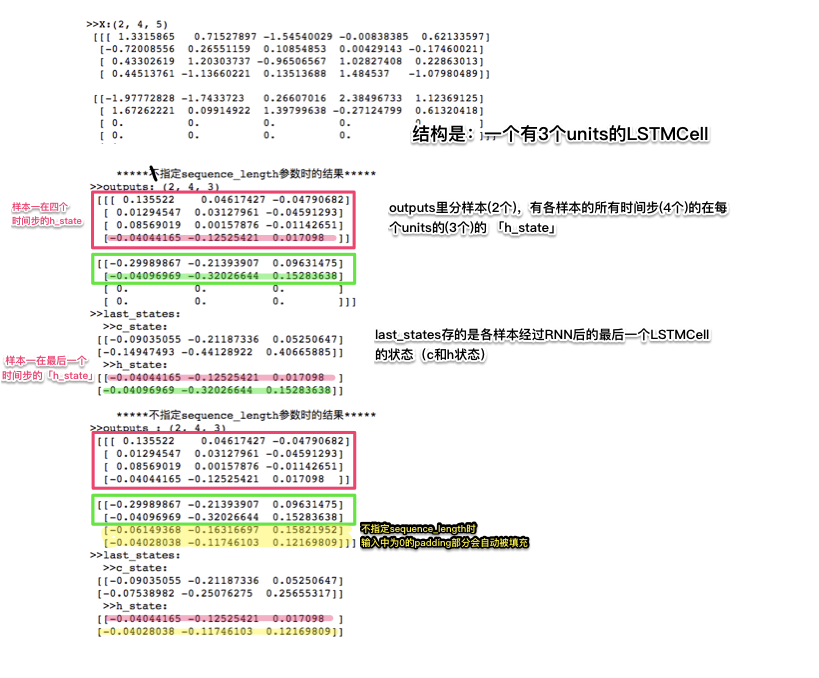

### 单层LSTM

In [41]:
tf.reset_default_graph()
np.random.seed(10)
# batch_size:2  timesteps:4 inputs:5
# 在NLP任务可以理解为：2段语料，每个语料4个词（索引），每个词5维向量
X = np.random.randn(2,4,5)  
X[1, 2:] = 0  # 指定索引位置的元素全置为0
print(">>X:{}\n".format(X.shape),X)
X_lengths = [4, 2]  # 手动指定各batch里有效数据（非0数据）的步长

lstm_size = 3
lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_size)
init_state = lstm_cell.zero_state(X.shape[0], dtype=tf.float64)  # 按batch_size全0初始化state(c_state和h_state)
outputs, last_states = tf.nn.dynamic_rnn(cell=lstm_cell, 
                                         inputs=X, 
                                         initial_state=init_state,
                                         sequence_length=X_lengths)

# 不告诉rnn各batch里非0数据的长度（真实步长）
outputs_, last_states_ = tf.nn.dynamic_rnn(cell=lstm_cell, 
                                         inputs=X, 
                                         initial_state=init_state)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i = sess.run(init_state)
    print(">>init_state:\n")
    print("  >>c_state:\n", i.c)
    print("  >>h_state:\n", i.h)
    print("\n"," "*2,"*****指定sequence_length参数时的结果*****")
    o,s = sess.run([outputs,last_states])
    print(">>outputs: {}\n".format(o.shape), o)
    print(">>last_states:")
    print("  >>c_state:\n", s.c)
    print("  >>h_state:\n", s.h)

    print("\n"," "*2,"*****不指定sequence_length参数时的结果*****")
    o_,s_ = sess.run([outputs_,last_states_])
    print(">>outputs_: {}\n".format(o_.shape), o_)
    print(">>last_states:")
    print("  >>c_state:\n", s_.c)
    print("  >>h_state:\n", s_.h)
    
    print("不指定时内部会自动填充，对结果有一定影响")

>>X:(2, 4, 5)
 [[[ 1.3315865   0.71527897 -1.54540029 -0.00838385  0.62133597]
  [-0.72008556  0.26551159  0.10854853  0.00429143 -0.17460021]
  [ 0.43302619  1.20303737 -0.96506567  1.02827408  0.22863013]
  [ 0.44513761 -1.13660221  0.13513688  1.484537   -1.07980489]]

 [[-1.97772828 -1.7433723   0.26607016  2.38496733  1.12369125]
  [ 1.67262221  0.09914922  1.39799638 -0.27124799  0.61320418]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]]
>>init_state:

  >>c_state:
 [[0. 0. 0.]
 [0. 0. 0.]]
  >>h_state:
 [[0. 0. 0.]
 [0. 0. 0.]]

    *****指定sequence_length参数时的结果*****
>>outputs: (2, 4, 3)
 [[[-4.00027092e-02  7.33641521e-02 -6.64417050e-02]
  [-1.17492935e-02  5.95997232e-02 -9.63026177e-02]
  [-2.01019384e-04  3.00679067e-02 -7.42396759e-02]
  [ 1.62854652e-01 -2.04529746e-01  8.80030620e-02]]

 [[ 3.92057658e-01  2.74925040e-02  1.84443615e-01]
  [-1.33500804e-01 -3.64166122e-02  1.85011729e-01]
 

### 多层LSTM

In [30]:
tf.reset_default_graph()
np.random.seed(10)
# batch_size:2  timesteps:4 inputs:5
# 在NLP任务可以理解为：2段语料，每个语料4个词（索引），每个词5维向量
X = np.random.randn(2,4,5).astype(np.float32)
X[1, 2:] = 0  # 指定索引位置的元素全置为0
print(">>X:{}\n".format(X.shape),X)
X_lengths = [4, 2]  # 手动指定各batch里有效数据（非0数据）的步长

def make_cell(hidden_size:int, is_training:bool=True, keep_prob:float=0.8):
    cell = tf.contrib.rnn.LSTMBlockCell(hidden_size, forget_bias=0.0)
    if is_training and keep_prob < 1:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell
layer_num = 2
hidden_size = 3
mlstm_cell = tf.contrib.rnn.MultiRNNCell([make_cell(hidden_size) for _ in range(layer_num)], state_is_tuple=True)
init_state = mlstm_cell.zero_state(X.shape[0], dtype=tf.float32)

outputs, last_states = tf.nn.dynamic_rnn(cell=mlstm_cell, 
                                         inputs=X, 
                                         initial_state=init_state,
                                         sequence_length=X_lengths)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i = sess.run(init_state)
    for j in range(layer_num):
        print(">>layer_{} init_state:".format(j))
        print("  >>c_state:\n", i[j].c)
        print("  >>h_state:\n", i[j].h)
    print("\n"," "*2,"*****指定sequence_length参数时的结果*****")
    o,s = sess.run([outputs,last_states])
    print(">>outputs: {}\n".format(o.shape), o)
    print(">>last_state: \n")
    s
    for j in range(layer_num):
        print(">>layer_{} last_state:".format(j))
        print("  >>c_state:\n", s[j].c)
        print("  >>h_state:\n", s[j].h)
    print("最后一层LSTMCell-layer的最后的h_state:\n", s[-1][1])
    print("outputs取结果:\n", o[:,-1,:])
    print("******【多层LSTM为什么outputs和last_states的结果不一致？】*****")
    

>>X:(2, 4, 5)
 [[[ 1.3315865   0.715279   -1.5454003  -0.00838385  0.621336  ]
  [-0.72008556  0.26551157  0.10854852  0.00429143 -0.17460021]
  [ 0.4330262   1.2030374  -0.96506566  1.028274    0.22863013]
  [ 0.44513762 -1.1366022   0.13513687  1.484537   -1.0798049 ]]

 [[-1.9777282  -1.7433723   0.26607016  2.3849673   1.1236912 ]
  [ 1.6726222   0.09914921  1.3979964  -0.27124798  0.6132042 ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]]
>>layer_0 init_state:
  >>c_state:
 [[0. 0. 0.]
 [0. 0. 0.]]
  >>h_state:
 [[0. 0. 0.]
 [0. 0. 0.]]
>>layer_1 init_state:
  >>c_state:
 [[0. 0. 0.]
 [0. 0. 0.]]
  >>h_state:
 [[0. 0. 0.]
 [0. 0. 0.]]

    *****指定sequence_length参数时的结果*****
>>outputs: (2, 4, 3)
 [[[-0.         -0.06685475  0.05350018]
  [-0.02643461 -0.          0.06014353]
  [-0.03989332 -0.07231743  0.08154355]
  [-0.08507713 -0.05776649  0.11979303]]

 [[-0.01244621  0.         -0.0018814 ]
  [-0.

(LSTMStateTuple(c=array([[-0.21703784,  0.16378157, -0.6912414 ],
        [ 0.09554495,  0.25792992,  0.16306643]], dtype=float32), h=array([[-0.10602103,  0.07780182, -0.24951063],
        [ 0.03190678,  0.19082792,  0.07272626]], dtype=float32)),
 LSTMStateTuple(c=array([[-0.12305219, -0.09302016,  0.19823383],
        [-0.03140065,  0.08977782, -0.01463748]], dtype=float32), h=array([[-0.0680617 , -0.04621319,  0.09583442],
        [-0.01670014,  0.04395096, -0.00766255]], dtype=float32)))

>>layer_0 last_state:
  >>c_state:
 [[-0.21703784  0.16378157 -0.6912414 ]
 [ 0.09554495  0.25792992  0.16306643]]
  >>h_state:
 [[-0.10602103  0.07780182 -0.24951063]
 [ 0.03190678  0.19082792  0.07272626]]
>>layer_1 last_state:
  >>c_state:
 [[-0.12305219 -0.09302016  0.19823383]
 [-0.03140065  0.08977782 -0.01463748]]
  >>h_state:
 [[-0.0680617  -0.04621319  0.09583442]
 [-0.01670014  0.04395096 -0.00766255]]
最后一层LSTMCell-layer的最后的h_state:
 [[-0.0680617  -0.04621319  0.09583442]
 [-0.01670014  0.04395096 -0.00766255]]
outputs取结果:
 [[-0.08507713 -0.05776649  0.11979303]
 [ 0.          0.          0.        ]]
******【多层LSTM为什么outputs和last_states的结果不一致？】*****


### 输入改变?
如果是想预测序列 `[1,3,4], [1,5,6], [1,7,8]`这样的，怎么写？

#### 构造一个求和的数据集

In [66]:
def get_one_sample():
    a = np.random.randint(10)
    b = np.random.randint(10)
    c = a + b
    return np.array([a,b,c])

data = np.array([get_one_sample() for _ in range(1000)]).astype(np.float32)
print(">>> data 前三个示例: {}\n".format(data.shape),data[:3])
dataX = data[:,:2]
dataY = data[:,-1]
print(">>> dataX 前三个示例: {}\n".format(dataX.shape),dataX[:3])
print(">>> dataY 前三个示例: {}\n".format(dataY.shape),dataY[:3])

>>> data 前三个示例: (1000, 3)
 [[4. 0. 4.]
 [5. 2. 7.]
 [7. 2. 9.]]
>>> dataX 前三个示例: (1000, 2)
 [[4. 0.]
 [5. 2.]
 [7. 2.]]
>>> dataY 前三个示例: (1000,)
 [4. 7. 9.]


In [67]:
with tf.Session() as sess:
    rr = sess.run(tf.one_hot(dataX,depth=10))
    rr[:5]
    rr.shape

array([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

(1000, 2, 10)

In [69]:
tf.reset_default_graph()
np.random.seed(10)

X = tf.one_hot(dataX,depth=10)
lstm_size = 10
lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_size)
init_state = lstm_cell.zero_state(X.shape[0], dtype=tf.float32)  # 按batch_size全0初始化state(c_state和h_state)

outputs_, last_states_ = tf.nn.dynamic_rnn(cell=lstm_cell, 
                                         inputs=X, 
                                         initial_state=init_state)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i = sess.run(init_state)
    print(">>init_state:\n")
    print("  >>c_state:\n", i.c.shape)
    print("  >>h_state:\n", i.h.shape)
    o_,s_ = sess.run([outputs_,last_states_])
    print(">>outputs_: {}\n".format(o_.shape), o_[:3])
    print(">>last_states:")
    print("  >>c_state: {}\n".format(s_.c.shape),s_.c[:3])
    print("  >>h_state: {}\n".format(s_.h.shape),s_.h[:3])
    print("最后取h_state结果")

>>init_state:

  >>c_state:
 (1000, 10)
  >>h_state:
 (1000, 10)
>>outputs_: (1000, 2, 10)
 [[[-0.04211247 -0.02932047 -0.06340045 -0.04484668 -0.01763662
    0.00262237 -0.03702587  0.06863484  0.04493661 -0.02921654]
  [-0.01685643 -0.0471762   0.02061565 -0.06517877 -0.05379388
    0.05841389 -0.07045184  0.10026589  0.07507515 -0.0453834 ]]

 [[ 0.08440932  0.07027771  0.0778267  -0.0717489  -0.0375006
   -0.06211352 -0.05259567 -0.06691046  0.00659753 -0.02282565]
  [ 0.07340768  0.10296321  0.01249476 -0.04643915 -0.11214029
   -0.01283126 -0.0870856  -0.04217808  0.04808539 -0.09892576]]

 [[ 0.09099711 -0.00368997 -0.04909451  0.06993049 -0.06639816
   -0.06334572  0.06333949  0.04525549 -0.00656219 -0.05600703]
  [ 0.05978833  0.03799339 -0.08636446  0.06402253 -0.14320287
   -0.03537314 -0.01145664  0.06538662  0.04630817 -0.11234458]]]
>>last_states:
  >>c_state: (1000, 10)
 [[-0.03700762 -0.0836051   0.03550662 -0.12588088 -0.11793496  0.11970818
  -0.13479742  0.19236237  

### 对`dynamic_rnn`的展开实现

In [ ]:
# **步骤6：方法一，调用 dynamic_rnn() 来让我们构建好的网络运行起来
# ** 当 time_major==False 时， outputs.shape = [batch_size, timestep_size, hidden_size] 
# ** 所以，可以取 h_state = outputs[:, -1, :] 作为最后输出
# ** state.shape = [layer_num, 2, batch_size, hidden_size], 
# ** 或者，可以取 h_state = state[-1][1] 作为最后输出
# ** 最后输出维度是 [batch_size, hidden_size]
# outputs, state = tf.nn.dynamic_rnn(mlstm_cell, inputs=X, initial_state=init_state, time_major=False)
# h_state = outputs[:, -1, :]  # 或者 h_state = state[-1][1]

# *************** 为了更好的理解 LSTM 工作原理，我们把上面 步骤6 中的函数自己来实现 ***************
# 通过查看文档你会发现， RNNCell 都提供了一个 __call__()函数（见最后附），我们可以用它来展开实现LSTM按时间步迭代。
# **步骤6：方法二，按时间步展开计算
outputs = list()
state = init_state
with tf.variable_scope('RNN'):
    for timestep in range(timestep_size):
        if timestep > 0:
            tf.get_variable_scope().reuse_variables()
        # 这里的state保存了每一层 LSTM 的状态
        (cell_output, state) = mlstm_cell(X[:, timestep, :], state)
        outputs.append(cell_output)
h_state = outputs[-1]
tf.summary.histogram("h_state",h_state)